In [1]:
#Load the data from the pickle file
import pickle
import networkx as nx
import torch
import matplotlib.pyplot as plt


# An exception to limit the maximum number of allowed transformations 
class NbTranformationException(Exception):
    pass

# An exception to limit the maximum number of read-write accesses. 
class NbAccessException(Exception):
    pass

# An exception to limit the maximum number of nested loops. Currently set to 5.
class LoopsDepthException(Exception):
    pass

# Maximum sequence of transformations (reversal, interchange and skewing) allowed. Currently set to 4 
MAX_NUM_TRANSFORMATIONS = 4

# Maximum size of the tags vector representing each transformation
MAX_TAGS = 16

# Maximum depth of a loop nest for each computation
MAX_DEPTH = 5

# Maximum length of expressions in the dataset
MAX_EXPR_LEN = 66
# Function to read and display the content of a pickle file
def read_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

# Example file paths
train_file_path = r"train_data_sample_500-programs_60k-schedules.pkl"

val_file_path = "val_data_sample_125-programs_20k-schedules.pkl"

key_num = 0 #Select any number from 0 to 499 to select a program
prop_no = 5 #Select any number from 0 to 6 to select a program attribute
# Load the data which contains the 500 programs
data = read_pickle_file(train_file_path)
#print(data.keys())
key = list(data.keys())[key_num] # Get the key to select a program
program = data[key]  # Select the program using the key
program_keys=program.keys()  # Get the keys of each program (7 keys are there)
# ['filename', 'node_name',  'parameters', 'program_annotation','initial_execution_time','schedules_list','exploration_time']
# <class 'str'>,<class 'str'>,<class 'dict'>,<class 'dict'>,  <class 'float'>,        <class 'list'>,   <class 'dict'>
program_keys_list=list(program_keys)

attr =program[program_keys_list[prop_no]][0]['tree_structure']



In [2]:
def get_representation_template(program_dict, train_device="cpu"):
    # Set the max and min number of accesses allowed 
    max_accesses = 15
    min_accesses = 0

    comps_repr_templates_list = []
    comps_indices_dict = dict()
    comps_placeholders_indices_dict = dict()

    # Get the program JSON represenation
    program_json = program_dict["program_annotation"]
    
    # Get the computations (program statements) dictionary and order them according to the absolute_order attribute
    computations_dict = program_json["computations"]
    ordered_comp_list = sorted(
        list(computations_dict.keys()),
        key=lambda x: computations_dict[x]["absolute_order"],
    )
    # For each computation in the program
    for comp_index, comp_name in enumerate(ordered_comp_list):
        comp_dict = computations_dict[comp_name]
        # Check if the computation accesses conform to the minimum and maximum allowed
        if len(comp_dict["accesses"]) > max_accesses:
            raise NbAccessException
        
        if len(comp_dict["accesses"]) < min_accesses:
            raise NbAccessException
        
        # Check if the number of iterators for this computation doesn't surpass the maximum allowed
        if len(comp_dict["iterators"]) > MAX_DEPTH:
            raise LoopsDepthException
    
        comp_repr_template = []
        comp_repr_template.append(+comp_dict["comp_is_reduction"])

        iterators_repr = []
        
        # Add a representation of each loop of this computation
        for iter_i, iterator_name in enumerate(comp_dict["iterators"]):
            iterator_dict = program_json["iterators"][iterator_name]
            # Create a unique code for each loop
            c_code = "C" + str(comp_index)
            l_code = c_code + "-L" + str(iter_i)
            
            # Add a placeholder for transformations applied to this loop
            iterators_repr.extend(
                [
                    l_code + "Parallelized",
                    l_code + "Tiled",
                    l_code + "TileFactor",
                    l_code + "Fused",
                    l_code + "Shifted",
                    l_code + "ShiftFactor",
                ]
            )
        
        iterator_repr_size = int(len(iterators_repr) / len(comp_dict["iterators"]))
        
        # Add padding incase the number of loops is lower than the max
        iterators_repr.extend(
            [0] * iterator_repr_size * (MAX_DEPTH - len(comp_dict["iterators"]))
        )
        
        # Add two tags for whether unrolling was applied and the unrolling factor
        iterators_repr.extend([c_code + "-Unrolled", c_code + "-UnrollFactor"])

        # Add a placeholder for the other transformations to be applied (skewing, reversal and interchage)
        iterators_repr.append(c_code + "-TransformationTagsStart")
        iterators_repr.extend(["M"] * (MAX_TAGS * MAX_NUM_TRANSFORMATIONS - 2))
        iterators_repr.append(c_code + "-TransformationTagsEnd")
        
        # Adding initial constraint matrix
        iterators_repr.append(c_code+'-OgConstraintMatrixStart')
        iterators_repr.extend(['OgC']*((MAX_DEPTH*MAX_DEPTH*2)-2))
        iterators_repr.append(c_code+'-OgConstraintMatrixEnd')
        
        # Adding initial constraint vector
        iterators_repr.append(c_code+'-OgConstraintVectorStart')
        iterators_repr.extend(['V']*(MAX_DEPTH*2-2))
        iterators_repr.append(c_code+'-OgConstraintVectorEnd')
        
        # Adding transformed constraint matrix
        iterators_repr.append(c_code+'-ConstraintMatrixStart')
        iterators_repr.extend(['C']*((MAX_DEPTH*MAX_DEPTH*2)-2))
        iterators_repr.append(c_code+'-ConstraintMatrixEnd')
                              
        # Add the loop representation to the computation vector 
        comp_repr_template.extend(iterators_repr)
        
        # Pad the write access matrix and add it to the representation
        padded_write_matrix = pad_access_matrix(
            isl_to_write_matrix(comp_dict["write_access_relation"])
        )
        write_access_repr = [
            comp_dict["write_buffer_id"] + 1
        ] + padded_write_matrix.flatten().tolist()
        comp_repr_template.extend(write_access_repr)

        # Pad the read access matrix and add it to the representation 
        read_accesses_repr = []
        for read_access_dict in comp_dict["accesses"]:
            read_access_matrix = pad_access_matrix(
                read_access_dict["access_matrix"]
            )
            read_access_repr = (
                [+read_access_dict["access_is_reduction"]]
                + [read_access_dict["buffer_id"] + 1]
                + read_access_matrix.flatten().tolist()
            )
            read_accesses_repr.extend(read_access_repr)
        access_repr_len = (MAX_DEPTH + 1) * (MAX_DEPTH + 2) + 1 + 1
        read_accesses_repr.extend(
            [0] * access_repr_len * (max_accesses - len(comp_dict["accesses"]))
        )
        comp_repr_template.extend(read_accesses_repr)
        
        # Add the representation of this computation to the list of containing all computations
        comps_repr_templates_list.append(comp_repr_template)
        
        # Create a mapping between the features and their position in the representation
        comps_indices_dict[comp_name] = comp_index
        for j, element in enumerate(comp_repr_template):
            if isinstance(element, str):
                comps_placeholders_indices_dict[element] = (comp_index, j)
            
        
    # Create a representation of the loops independantly from the computations
    loops_repr_templates_list = []
    loops_indices_dict = dict()
    loops_placeholders_indices_dict = dict()

    for loop_index, loop_name in enumerate(program_json["iterators"]):
        # Create a unique code for each loop
        loop_repr_template = []
        l_code = "L" + loop_name
        
        # Add a placeholder for transformations applied to this loop
        loop_repr_template.extend(
            [
                l_code + "Parallelized",
                l_code + "Tiled",
                l_code + "TileFactor",
                l_code + "Fused",
                l_code + "Unrolled",
                l_code + "UnrollFactor",
                l_code + "Shifted",
                l_code + "ShiftFactor",
            ]
        )
        
        # Create a mapping between the features and their position in the representation
        loops_repr_templates_list.append(loop_repr_template)
        loops_indices_dict[loop_name] = loop_index
        for j, element in enumerate(loop_repr_template):
            if isinstance(element, str):
                loops_placeholders_indices_dict[element] = (loop_index, j)
    
    # Get the original version of the program 
    no_sched_json = program_dict["schedules_list"][0]
    
    # Make sure no fusion was applied on this version and get the original tree structure 
    assert "fusions" not in no_sched_json or no_sched_json["fusions"] == None
    orig_tree_structure = no_sched_json["tree_structure"]
    tree_annotation = copy.deepcopy(orig_tree_structure)
    
    # Add necessary attributes to the tree_structure
    #prog_graph = create_program_graph_with_dependencies_extended(program_dict, loops_indices_dict, comps_indices_dict)
    
    return (
        loops_indices_dict,
        comps_indices_dict,
        orig_tree_structure,
        comps_repr_templates_list,
        loops_repr_templates_list,
        comps_placeholders_indices_dict,
        loops_placeholders_indices_dict
    )
def pad_access_matrix(access_matrix):
    access_matrix = np.array(access_matrix)
    access_matrix = np.c_[np.ones(access_matrix.shape[0]), access_matrix]
    access_matrix = np.r_[[np.ones(access_matrix.shape[1])], access_matrix]
    padded_access_matrix = np.zeros((MAX_DEPTH + 1, MAX_DEPTH + 2))
    padded_access_matrix[
        : access_matrix.shape[0], : access_matrix.shape[1] - 1
    ] = access_matrix[:, :-1]
    padded_access_matrix[: access_matrix.shape[0], -1] = access_matrix[:, -1]

    return padded_access_matrix

# Tranfrom the access relations to matrices
def isl_to_write_matrix(isl_map):
    comp_iterators_str = re.findall(r"\[(.*)\]\s*->", isl_map)[0]
    buffer_iterators_str = re.findall(r"->\s*\w*\[(.*)\]", isl_map)[0]
    buffer_iterators_str = re.sub(r"\w+'\s=", "", buffer_iterators_str)
    comp_iter_names = re.findall(r"(?:\s*(\w+))+", comp_iterators_str)
    buf_iter_names = re.findall(r"(?:\s*(\w+))+", buffer_iterators_str)
    matrix = np.zeros([len(buf_iter_names), len(comp_iter_names) + 1])
    for i, buf_iter in enumerate(buf_iter_names):
        for j, comp_iter in enumerate(comp_iter_names):
            if buf_iter == comp_iter:
                matrix[i, j] = 1
                break
    return matrix

In [3]:
def create_program_graph_with_dependencies(program_dict):
    # Create directed graph
    G = nx.DiGraph()
    program_json = program_dict["program_annotation"]
    computations_dict = program_json["computations"]
    
    ordered_comp_list = sorted(
        list(computations_dict.keys()),
        key=lambda x: computations_dict[x]["absolute_order"],
    )
    
    # Add computation nodes with features (node attributes)
    for comp_name in ordered_comp_list:
        comp_dict = computations_dict[comp_name]
        features = {
            'absolute_order': comp_dict["absolute_order"],
            'comp_is_reduction': comp_dict["comp_is_reduction"],
            'expression_representation': comp_dict["expression_representation"],
            'write_access_relation': comp_dict["write_access_relation"],
            'data_type': comp_dict["data_type"]
        }
        G.add_node(comp_name, node_type='computation', **features)
    
    # Add iterator nodes with features (bounds)
    for iterator_name, iterator_dict in program_json["iterators"].items():
        features = {
            'lower_bound': iterator_dict['lower_bound'],
            'upper_bound': iterator_dict['upper_bound'],
            'parent_iterator': iterator_dict.get('parent_iterator', None),
            'child_iterators': iterator_dict.get('child_iterators', [])
        }
        G.add_node(iterator_name, node_type='iterator', **features)
    
    # Add edges for parent-child relationships between iterators
    for iterator_name, iterator_dict in program_json["iterators"].items():
        parent_iterator = iterator_dict.get("parent_iterator")
        if parent_iterator:
            G.add_edge(parent_iterator, iterator_name, edge_type="parent-child")
    
    # Add edges for dependencies between computations
    for comp_name in ordered_comp_list:
        comp_dict = computations_dict[comp_name]
        
        # Add write-read dependencies
        write_buffer = comp_dict.get("write_buffer_id", None)
        if write_buffer is not None:
            for other_comp in ordered_comp_list:
                if other_comp != comp_name:
                    other_comp_dict = computations_dict[other_comp]
                    for access in other_comp_dict["accesses"]:
                        if access["buffer_id"] == write_buffer:
                            G.add_edge(comp_name, other_comp, edge_type='write-read')
        
        # Add read dependencies
        for read_access in comp_dict["accesses"]:
            if read_access["buffer_id"] < len(ordered_comp_list):
                source_comp = ordered_comp_list[read_access["buffer_id"]]
                G.add_edge(source_comp, comp_name, edge_type='read',
                          is_reduction=read_access.get("access_is_reduction", False))
    
        # Add iterator-computation dependencies
        for iterator_name in comp_dict["iterators"]:
            G.add_edge(comp_name, iterator_name, edge_type='uses')
    
    # Clean edge attributes to ensure only edge-related details are there
    for u, v, edge_data in G.edges(data=True):
        # Ensure the edge only contains edge-related attributes
        edge_keys_to_remove = ['lower_bound', 'upper_bound', 'parent_iterator', 'child_iterators', 'node_type']
        for key in edge_keys_to_remove:
            if key in edge_data:
                del edge_data[key]
    
    return G


In [4]:
import re
import numpy as np
import copy
a,b,c,d,e,f,g =get_representation_template(program)
G=create_program_graph_with_dependencies(program)

In [5]:
def visualize_program_graph(G):
    # Visualize the graph
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(G, k=1.5, iterations=50)
    
    # Draw computation nodes
    comp_nodes = [node for node, attr in G.nodes(data=True) 
                 if attr.get('node_type') == 'computation']
    nx.draw_networkx_nodes(G, pos, nodelist=comp_nodes, 
                          node_color='lightblue', 
                          node_size=2000)
    
    # Draw iterator nodes
    iter_nodes = [node for node, attr in G.nodes(data=True) 
                 if attr.get('node_type') == 'iterator']
    nx.draw_networkx_nodes(G, pos, nodelist=iter_nodes, 
                          node_color='lightgreen', 
                          node_size=1500)
    
    # Draw edges with different colors based on type
    parent_child_edges = [(u, v) for (u, v, d) in G.edges(data=True) 
                          if d.get('edge_type') == 'parent-child']
    write_read_edges = [(u, v) for (u, v, d) in G.edges(data=True) 
                       if d.get('edge_type') == 'write-read']
    read_edges = [(u, v) for (u, v, d) in G.edges(data=True) 
                 if d.get('edge_type') == 'read']
    use_edges = [(u, v) for (u, v, d) in G.edges(data=True) 
                if d.get('edge_type') == 'uses']
    
    # Draw different types of edges
    nx.draw_networkx_edges(G, pos, edgelist=parent_child_edges, 
                          edge_color='orange', arrows=True)
    nx.draw_networkx_edges(G, pos, edgelist=write_read_edges, 
                          edge_color='red', arrows=True)
    nx.draw_networkx_edges(G, pos, edgelist=read_edges, 
                          edge_color='purple', arrows=True)
    nx.draw_networkx_edges(G, pos, edgelist=use_edges, 
                          edge_color='blue', arrows=True)
    
    # Add edge labels with direction indicators
    edge_labels = {}
    for u, v, d in G.edges(data=True):
        if d.get("edge_type") == "parent-child":
            edge_labels[(u, v)] = "Parent→Child"
        elif d.get("edge_type") == "write-read":
            edge_labels[(u, v)] = "W→R"
        elif d.get("edge_type") == "read":
            edge_labels[(u, v)] = "R"
        elif d.get("edge_type") == "uses":
            edge_labels[(u, v)] = "Uses Iterator"
    
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    
    # Add node labels and show features on nodes
    def node_label(node, attr):
        label = node
        if 'lower_bound' in attr:
            label += f"\nLB: {attr['lower_bound']}, UB: {attr['upper_bound']}"
        if 'expression_representation' in attr:
            label += f"\nExpr: {attr['expression_representation']['expr_type']}"
        return label
    
    labels = {node: node_label(node, attr) for node, attr in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_color="black")
    plt.title("Program Graph Representation with Dependencies and Directions")
    plt.axis('off')
    plt.savefig('Graph')
    plt.show()

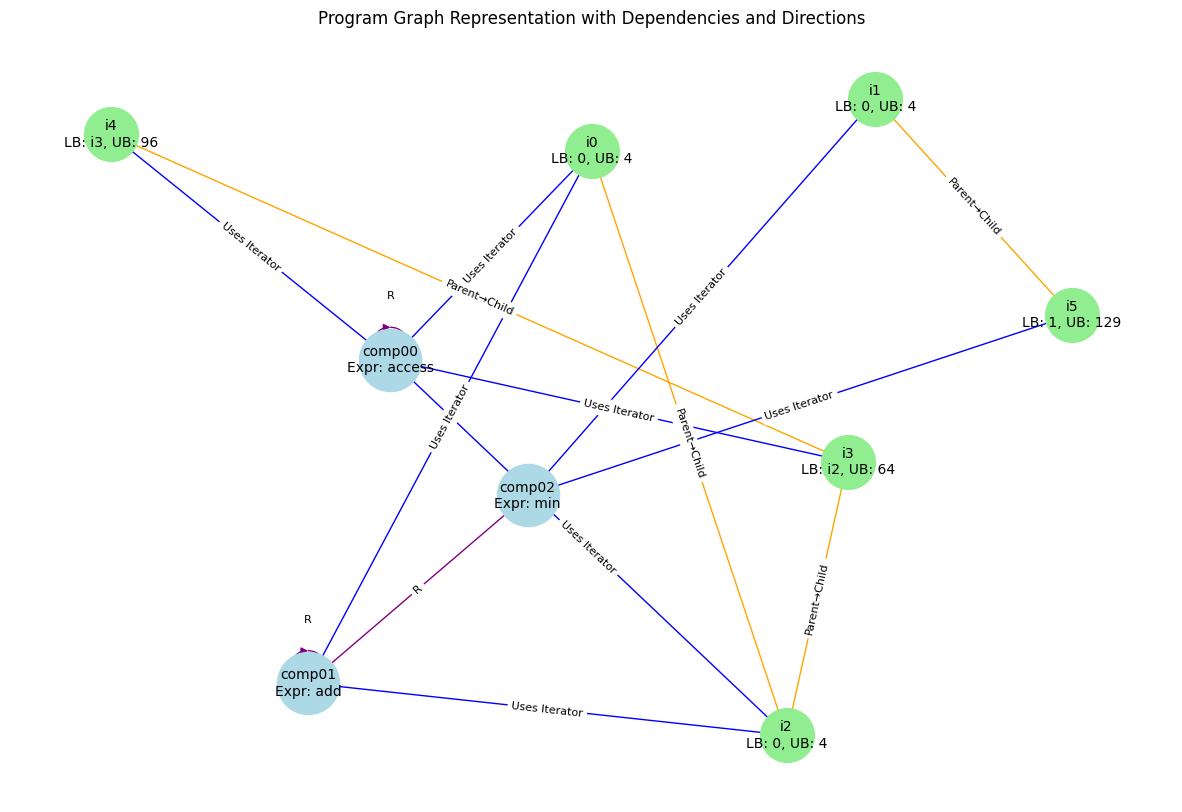

In [6]:
visualize_program_graph(G)

In [11]:
for node, attributes in G.nodes(data=True):
    print(f"Node: {node}")
    for key, value in attributes.items():
        print(f"  {key}: {value}")
for edge in G.edges(data=True):
    print(f"Edge: {edge}")

Node: comp00
  node_type: computation
  absolute_order: 1
  comp_is_reduction: False
  expression_representation: {'expr_type': 'access', 'children': []}
  write_access_relation: { comp00[i0, i2, i3, i4] -> buf00[i0, i2, i3, i4] }
  data_type: float64
Node: comp01
  node_type: computation
  absolute_order: 2
  comp_is_reduction: True
  expression_representation: {'expr_type': 'add', 'children': [{'expr_type': 'access', 'children': []}, {'expr_type': 'mul', 'children': [{'expr_type': 'value', 'children': []}, {'expr_type': 'access', 'children': []}]}]}
  write_access_relation: { comp01[i0, i2] -> buf02[i2] }
  data_type: float64
Node: comp02
  node_type: computation
  absolute_order: 3
  comp_is_reduction: True
  expression_representation: {'expr_type': 'min', 'children': [{'expr_type': 'sqrt', 'children': [{'expr_type': 'sqrt', 'children': [{'expr_type': 'sub', 'children': [{'expr_type': 'sqrt', 'children': [{'expr_type': 'add', 'children': [{'expr_type': 'mul', 'children': [{'expr_typ